# Sedimentation

In [1]:
from trustutils.jupyter import run

run.introduction("A. Gerschenfeld, Y. Gorsse")
run.description("Cas tests de sedimentation. Etat initial melange, et separation des phases par gravite.")
run.TRUST_parameters()

## Introduction 
 Validation made by : A. Gerschenfeld, Y. Gorsse



 Report generated 26/01/2022

### Description 
Cas tests de sedimentation. Etat initial melange, et separation des phases par gravite.

### TRUST parameters 
 * Version TRUST: 1.8.4
 * Binary used: /volatile/catA/ll258196/trust-code/exec/TRUST_mpi_opt (built on TRUST /volatile/catA/ll258196/trust-code/Validation/Rapports_automatiques/jupyter/Multiphase/sedimentation/build)

In [2]:
from trustutils.jupyter import run
run.reset()
run.addCase("Triangles" ,"cas.data")
run.addCase("Quadrangles" ,"cas.data")
run.addCase("Cartesian" ,"cas.data")
run.addCase("Locally_Refined" ,"cas.data")
run.printCases()
run.runCases()

### Test cases 
* Triangles/cas.data : 
* Quadrangles/cas.data : 
* Cartesian/cas.data : 
* Locally_Refined/cas.data : 


Running **with Sserver**...
  => A total of 4 cases were (successfully) run in 39.0s.


## Resultats

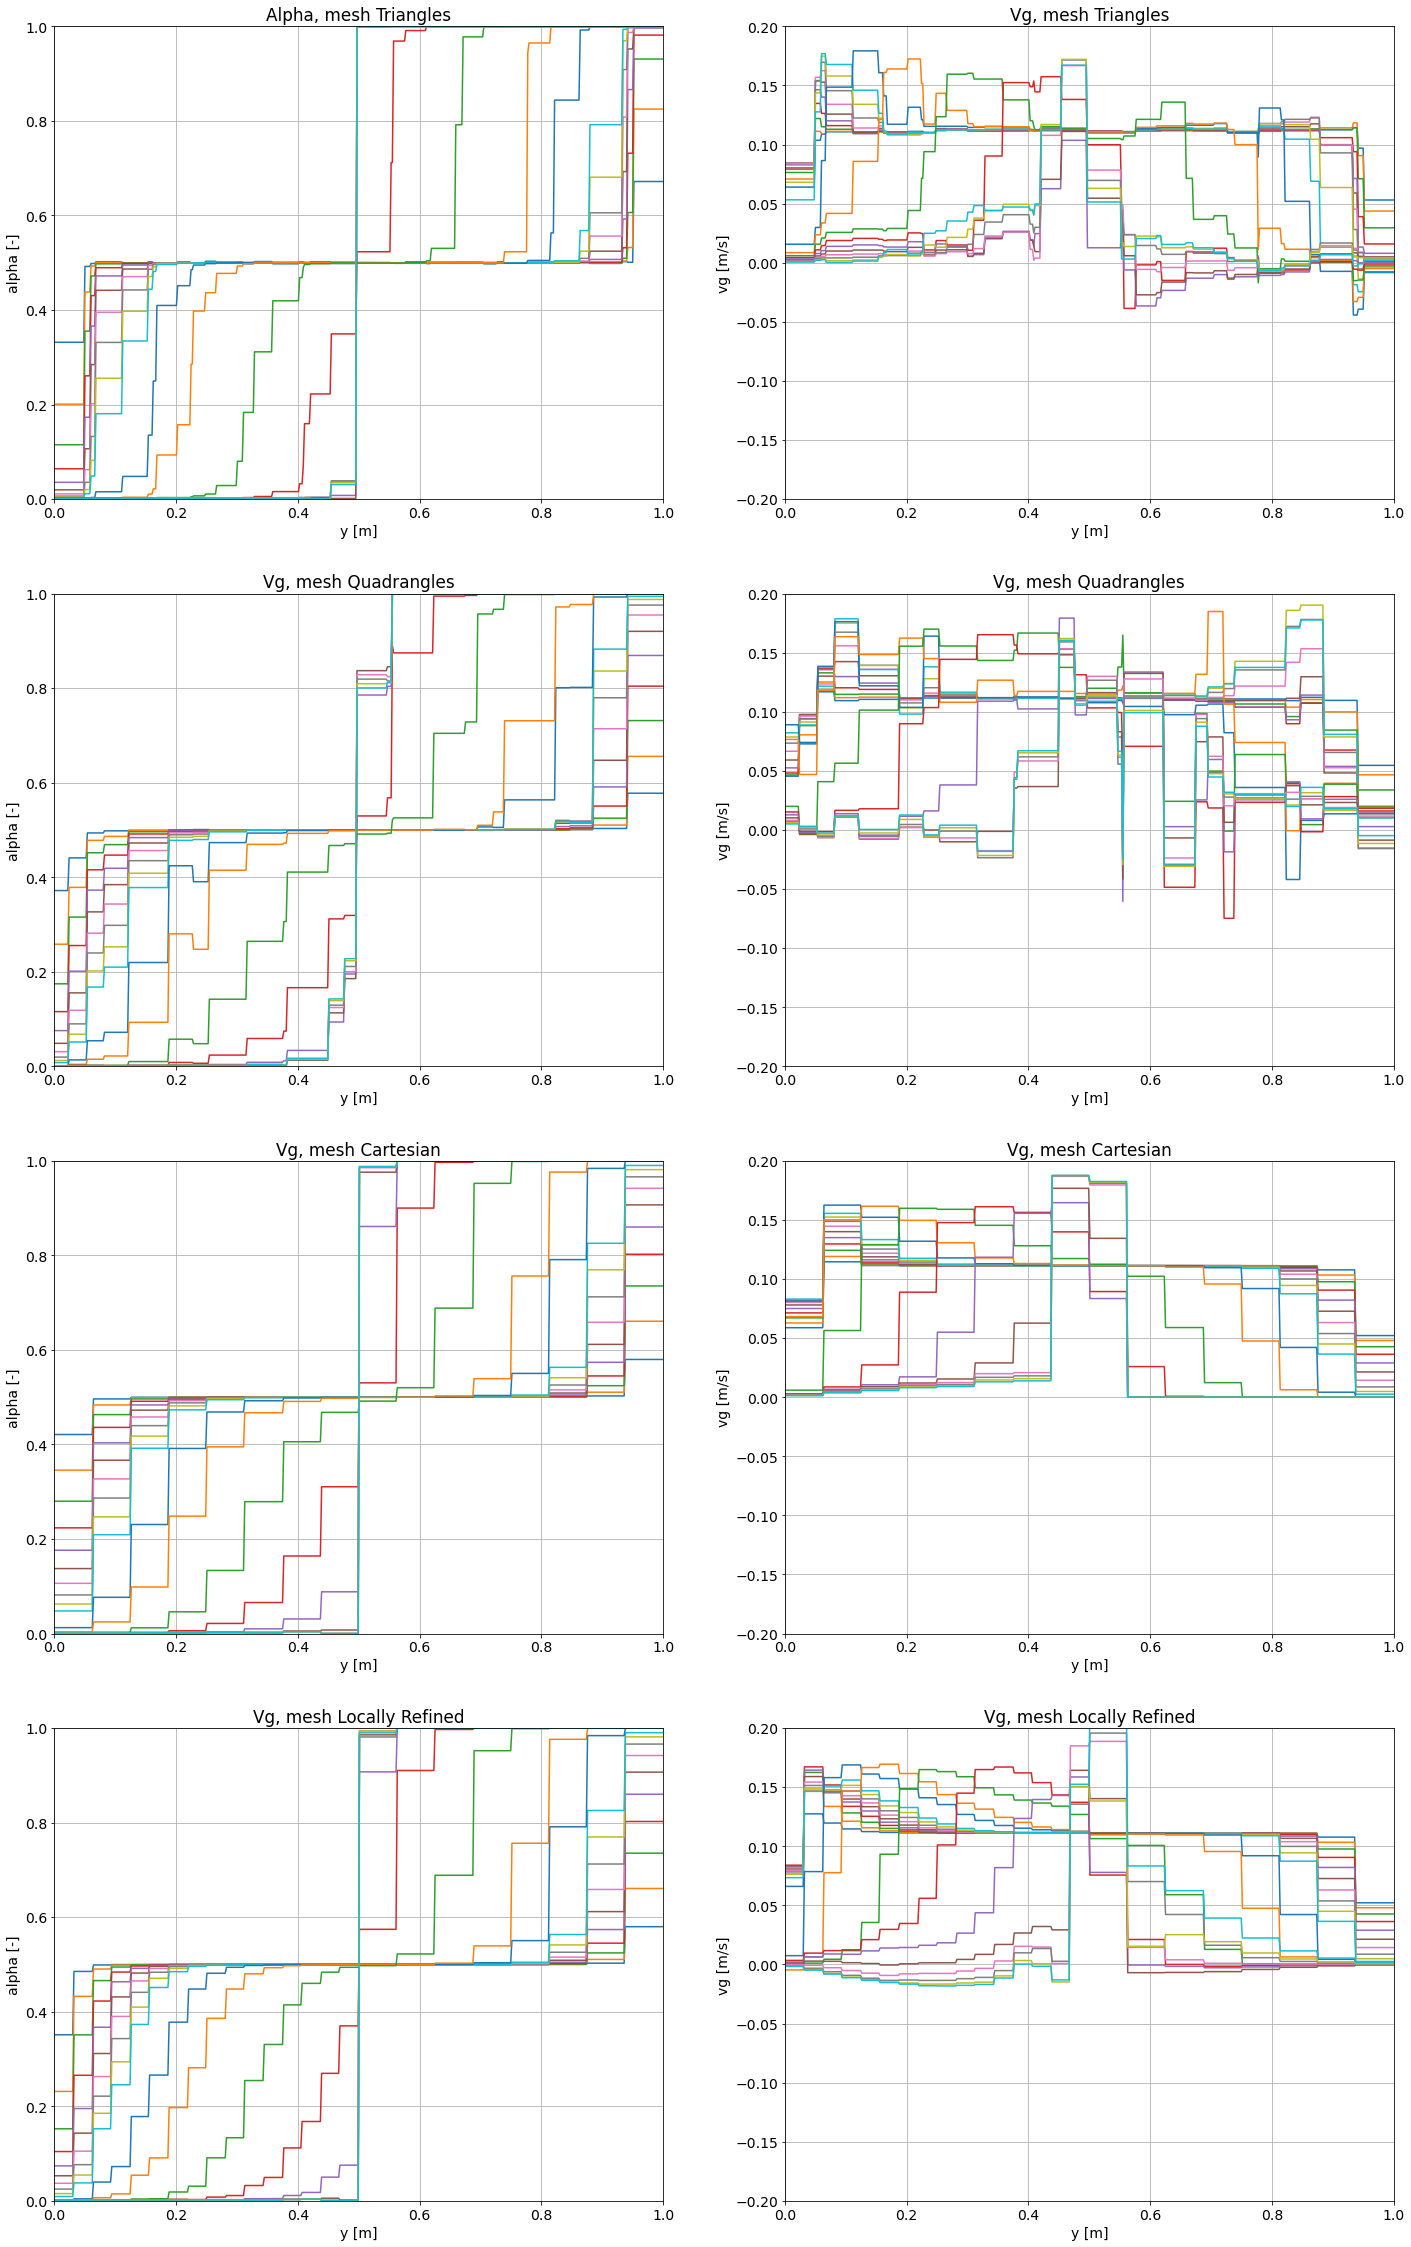

In [4]:
from trustutils import plot

a = plot.Graph("Alpha, mesh Triangles",nX=4,nY=2)
a.addSegment("Triangles/cas_ALPHA.son",value=0.1,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.2,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.3,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.4,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.5,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.6,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.7,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.8,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=0.9,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=1,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=1.5,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=2,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=3,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=4,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=5,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=6,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=7,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=8,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=9,label=None)
a.addSegment("Triangles/cas_ALPHA.son",value=10,label=None)
a.label("y [m]","alpha [-]")
a.visu(0,1,0,1)

a.addPlot([0,1],"Vg, mesh Triangles")
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.1,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.2,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.3,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.4,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.5,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.6,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.7,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.8,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=0.9,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=1,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=1.5,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=2,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=3,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=4,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=5,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=6,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=7,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=8,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=9,label=None)
a.addSegment("Triangles/cas_PROFIL_VG.son",var="y",value=10,label=None)
a.label("y [m]","vg [m/s]")
a.visu(0,1,-0.2,0.2)

a.addPlot([1,0],"Vg, mesh Quadrangles")
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.1,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.2,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.3,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.4,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.5,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.6,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.7,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.8,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=0.9,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=1,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=1.5,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=2,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=3,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=4,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=5,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=6,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=7,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=8,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=9,label=None)
a.addSegment("Quadrangles/cas_ALPHA.son",value=10,label=None)
a.label("y [m]","alpha [-]")
a.visu(0,1,0,1)

a.addPlot([1,1],"Vg, mesh Quadrangles")
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.1,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.2,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.3,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.4,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.5,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.6,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.7,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.8,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=0.9,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=1,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=1.5,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=2,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=3,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=4,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=5,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=6,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=7,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=8,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=9,label=None)
a.addSegment("Quadrangles/cas_PROFIL_VG.son",var="y",value=10,label=None)
a.label("y [m]","vg [m/s]")
a.visu(0,1,-0.2,0.2)


a.addPlot([2,0],"Vg, mesh Cartesian")
a.addSegment("Cartesian/cas_ALPHA.son",value=0.1,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.2,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.3,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.4,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.5,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.6,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.7,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.8,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=0.9,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=1,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=1.5,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=2,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=3,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=4,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=5,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=6,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=7,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=8,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=9,label=None)
a.addSegment("Cartesian/cas_ALPHA.son",value=10,label=None)
a.label("y [m]","alpha [-]")
a.visu(0,1,0,1)

a.addPlot([2,1],"Vg, mesh Cartesian")
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.1,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.2,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.3,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.4,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.5,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.6,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.7,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.8,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=0.9,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=1,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=1.5,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=2,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=3,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=4,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=5,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=6,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=7,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=8,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=9,label=None)
a.addSegment("Cartesian/cas_PROFIL_VG.son",var="y",value=10,label=None)
a.label("y [m]","vg [m/s]")
a.visu(0,1,-0.2,0.2)


a.addPlot([3,0],"Vg, mesh Locally Refined")
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.1,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.2,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.3,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.4,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.5,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.6,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.7,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.8,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=0.9,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=1,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=1.5,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=2,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=3,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=4,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=5,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=6,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=7,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=8,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=9,label=None)
a.addSegment("Locally_Refined/cas_ALPHA.son",value=10,label=None)
a.label("y [m]","alpha [-]")
a.visu(0,1,0,1)

a.addPlot([3,1],"Vg, mesh Locally Refined")
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.1,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.2,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.3,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.4,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.5,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.6,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.7,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.8,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=0.9,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=1,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=1.5,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=2,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=3,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=4,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=5,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=6,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=7,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=8,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=9,label=None)
a.addSegment("Locally_Refined/cas_PROFIL_VG.son",var="y",value=10,label=None)
a.label("y [m]","vg [m/s]")
a.visu(0,1,-0.2,0.2)
